# Structural Estimation

Natasha Watkins

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Question 1

Part a)

In [59]:
claims = pd.read_csv('clms.txt', header=None, names=['claims'])
claims.head()

,claims
0,361.65
1,123.04
2,541.77
3,862.90
4,55.60


In [60]:
claims.agg(['mean', 'median', 'max', 'min', 'std'])

,claims
mean,720.277975
median,172.210000
max,227967.250000
min,0.010000
std,3972.850824


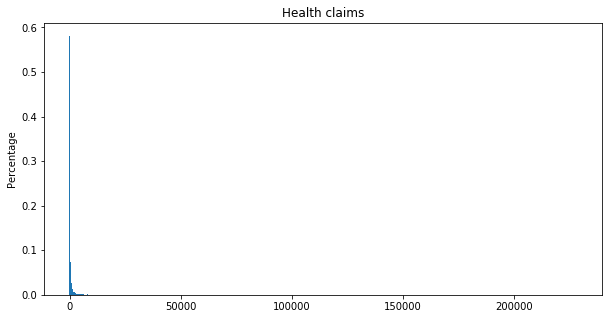

In [61]:
hist, bins = np.histogram(claims.dropna(), bins=1000, density=True)
hist = hist / hist.sum()
plt.figure(figsize=(10, 5))
plt.bar(np.linspace(bins.min(), bins.max(), len(hist)), hist, width=bins[1])
plt.title('Health claims')
plt.ylabel('Percentage')
plt.show()

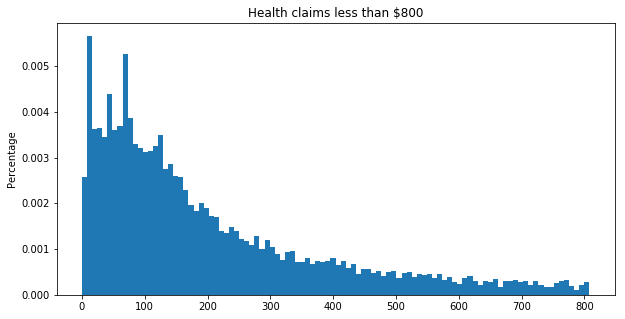

In [62]:
hist_new, bins_new = np.histogram(claims[claims <= 800].dropna(), bins=100, density=True)
hist_new = hist_new / hist.sum()
plt.figure(figsize=(10, 5))
plt.bar(np.linspace(bins_new.min(), bins_new.max(), len(hist_new)), 
        hist_new, width=bins_new[1]+0.1, align='edge')
plt.title('Health claims less than $800')
plt.ylabel('Percentage')
plt.show()

The second histogram is easier to interpret as it excludes outliers.

Part b)

In [63]:
# Initial guesses
β_0 = claims.var() / claims.mean()
α_0 = claims.mean() / β_0
X = claims.values

In [64]:
from scipy.special import gamma
from scipy.optimize import minimize

# Log likelihood of gamma(α, β) distribution
def logL_gamma(params, X):
    α, β = params
    T = len(X)
    logL = -T * α * np.log(β) + (α - 1) * np.sum(np.log(X)) - \
           (1 / β) * np.sum(X) - T * gamma(α)
    return -logL  # Return negative log-likelihood

In [65]:
MLE_gamma = minimize(logL_gamma, [α_0, β_0], 
                     args=X, method='Nelder-Mead')

α_hat, β_hat = MLE_gamma.x

# Function to plot estimated gamma(α, β) distribution
g = lambda α, β, x: (β**(-α) * x**(α - 1) * np.exp(-x / β)) / gamma(α)

print(f'α = {α_hat:.3f}')
print(f'β = {β_hat:.3f}')
print(f'logL = {-MLE_gamma.fun:.3f}')

α = 0.671
β = 1072.790
logL = -89397.302


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


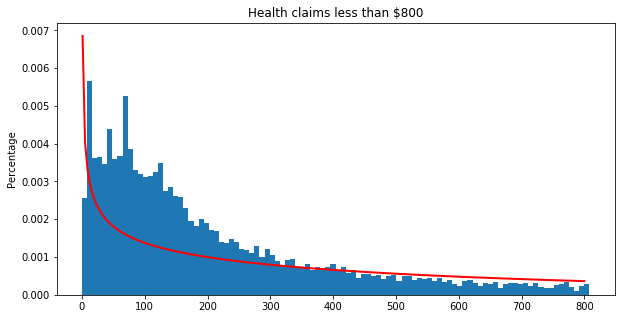

In [66]:
plt.figure(figsize=(10, 5))
plt.bar(np.linspace(bins_new.min(), bins_new.max(), len(hist_new)), 
        hist_new, width=bins_new[1]+0.1, align='edge')

x_grid = np.linspace(1, 800, 200)
plt.plot(x_grid, g(α_hat, β_hat, x_grid), c='r', lw=2)

plt.title('Health claims less than $800')
plt.ylabel('Percentage')
plt.show()

Part c)

In [67]:
# Log likelihood of generalized gamma(α, β, m) distribution
def logL_gamma_generalized(params, X):
    α, β, m = params
    T = len(X)
    logL = T * np.log(m) - T * α * np.log(β) + (α - 1) * np.sum(np.log(X)) - \
            np.sum((X / β)**m) - T * gamma(α / m)
    return -logL  # Return negative log-likelihood

In [68]:
MLE_gamma_ga = minimize(logL_gamma_generalized, [α_0, β_0, 1], 
                        args=X, method='Nelder-Mead')

α_hat_ga, β_hat_ga, m_hat_ga = MLE_gamma_ga.x
print(f'α = {α_hat_ga:.3f}')
print(f'β = {β_hat_ga:.3f}')
print(f'm = {m_hat_ga:.3f}')
print(f'logL = {-MLE_gamma_ga.fun:.3f}')

α = 0.922
β = 55.696
m = 0.435
logL = -86221.785


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


In [69]:
# Function to plot estimated generalized gamma distribution
ga = lambda α, β, m, x: (m / (β**α) * x**(α - 1) * np.exp(-(x / β)**m)) / gamma(α / m)

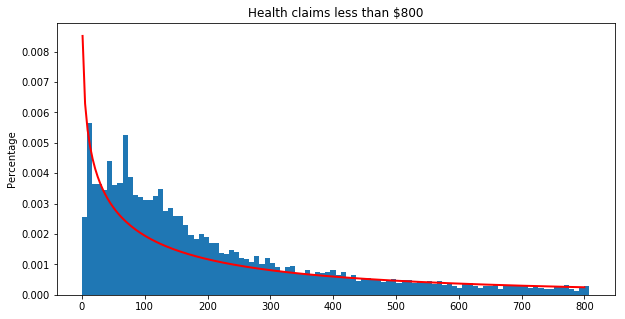

In [70]:
plt.figure(figsize=(10, 5))
plt.bar(np.linspace(bins_new.min(), bins_new.max(), len(hist_new)), 
        hist_new, width=bins_new[1]+0.1, align='edge')

plt.plot(x_grid, ga(α_hat_ga, β_hat_ga, m_hat_ga, x_grid), c='r', lw=2)

plt.title('Health claims less than $800')
plt.ylabel('Percentage')
plt.show()

Part d)

In [71]:
from scipy.special import beta


# Log likelihood of GB2 distribution
def logL_gb2(params, X):
    a, b, p, q = params
    T = len(X)
    logL = T * np.log(np.abs(a)) + (a * p - 1) * np.sum(np.log(X)) - T * a * p * np.log(b) - \
           T * np.log(beta(p, q)) - (p + q) * np.sum(np.log(1 + (X / b)**a))
    return -logL

In [74]:
MLE_gb2 = minimize(logL_gb2, [α_hat_ga, β_hat_ga, m_hat_ga, 200], 
                        args=X, method='L-BFGS-B')

In [76]:
a_hat, b_hat, p_hat, q_hat = MLE_gb2.x


## Exercise 2

In [34]:
macro = pd.read_csv('MacroSeries.txt', header=None,
                    names=['c', 'k', 'w', 'r', 'y'])

β = 0.99

In [49]:
from scipy.optimize import root

def find_z(α, ρ, μ, σ, w, k):
    T = len(w)
    z = np.zeros(T)
    z[0] = μ
    z[1] = μ
    z_root = lambda z_i, w, k: w - (1 - α) * np.exp(z_i) * k**α
    for i in range(2, T):
        z_i = root(z_root, μ, args=(k[i], w[i]))
        print(z_i)
        z[i] = z[i]
    return z

In [50]:
find_z(0.5, 0.8, 0.5, 0.5, macro['w'], macro['k'])

    fjac: array([[-1.]])
     fun: array([8648252.64769701])
 message: 'The solution converged.'
    nfev: 4
     qtf: array([-8648252.64769701])
       r: array([2.82142031e+23])
  status: 1
 success: True
       x: array([0.5])
    fjac: array([[-1.]])
     fun: array([7807410.77418087])
 message: 'The solution converged.'
    nfev: 4
     qtf: array([-7807410.77418087])
       r: array([2.65430445e+23])
  status: 1
 success: True
       x: array([0.5])
    fjac: array([[-1.]])
     fun: array([6909686.42996706])
 message: 'The solution converged.'
    nfev: 4
     qtf: array([-6909686.42996706])
       r: array([2.58984536e+23])
  status: 1
 success: True
       x: array([0.5])
    fjac: array([[-1.]])
     fun: array([6578206.58972943])
 message: 'The solution converged.'
    nfev: 4
     qtf: array([-6578206.58972943])
       r: array([2.4188424e+23])
  status: 1
 success: True
       x: array([0.5])
    fjac: array([[-1.]])
     fun: array([5737680.29353191])
 message: 'The solut

array([0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

In [53]:
claims

,claims
0,361.65
1,123.04
2,541.77
3,862.90
4,55.60
5,3728.56
6,70.00
7,730.63
8,420.56
9,81.63
